# Resize Image

이제는 알파벳 이미지를 crop - resize - padding의 과정을 거쳐 균일한 형태로 만들어야 한다.
- 현재는 canvas_size = 256, font_size = 150

In [1]:
from common.dataset import FontDataset
from common.dataset import PickledImageProvider
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = './dataset/integrated/'

In [3]:
display = PickledImageProvider(data_dir+'train_2.obj')

processed 1000 examples
processed 2000 examples
processed 3000 examples
processed 4000 examples
processed 5000 examples
processed 6000 examples
processed 7000 examples
processed 8000 examples
processed 9000 examples
processed 10000 examples
processed 11000 examples
processed 12000 examples
processed 13000 examples
processed 14000 examples
processed 15000 examples
processed 16000 examples
processed 17000 examples
processed 18000 examples
processed 19000 examples
processed 20000 examples
processed 21000 examples
processed 22000 examples
processed 23000 examples
processed 24000 examples
processed 25000 examples
processed 26000 examples
processed 27000 examples
processed 28000 examples
processed 29000 examples
processed 30000 examples
processed 31000 examples
processed 32000 examples
processed 33000 examples
processed 34000 examples
processed 35000 examples
processed 36000 examples
processed 37000 examples
processed 38000 examples
processed 39000 examples
processed 40000 examples
processed

In [4]:
dataset = FontDataset(display)

In [5]:
len(dataset)

14716

In [6]:
dataset[0][0]

{'category': 2,
 'font': 30,
 'alphabet': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])}

In [7]:
sample = dataset[0][1]
print(type(sample))

<class 'bytes'>


### Bytes 타입을 numpy array로 변경

In [8]:
import io

In [9]:
sample_img = Image.open(io.BytesIO(sample))

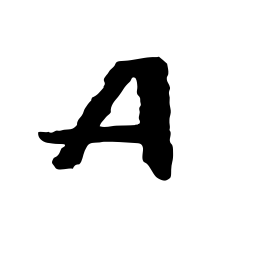

In [10]:
sample_img

In [11]:
sample_arr = np.array(sample_img) 

In [12]:
sample_arr

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [13]:
type(sample_arr)

numpy.ndarray

## Crop

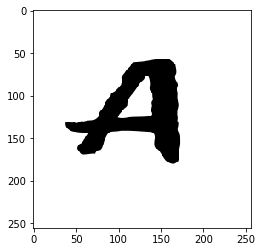

In [14]:
plt.imshow(sample_arr, cmap='gray')
plt.show()

먼저, normalize를 진행하자.

In [23]:
def normalize_image(img):
    """
    Make image zero centered and in between (-1, 1)
    """
    normalized = (img / 127.5) - 1.
    return normalized

In [24]:
sample_arr = normalize_image(sample_arr)

In [25]:
sample_arr

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [26]:
# 거의 흰색인 경우
256 - sum(sample_arr[0])

0.0

In [27]:
# 글자가 포함된 경우
256 - sum(sample_arr[60])

71.84313725490193

In [32]:
def tight_crop_image(img, verbose=False, resize_fix_h=False):
    img_size = img.shape[0]
    full_white = img_size # 256
    col_sum = np.where(full_white - np.sum(img, axis=0) > 1)
    row_sum = np.where(full_white - np.sum(img, axis=1) > 1)

    y1, y2 = row_sum[0][0], row_sum[0][-1]
    x1, x2 = col_sum[0][0], col_sum[0][-1]
    cropped_image = img[y1:y2, x1:x2]
    cropped_image_size = cropped_image.shape
    
    if verbose:
        print('(left x1, top y1):', (x1, y1))
        print('(right x2, bottom y2):', (x2, y2))
        print('cropped_image size:', cropped_image_size)
        
    if resize_fix_h:
        origin_h, origin_w = cropped_image.shape
        resize_w = int(origin_w / origin_h * resize_fix_h)
        resize_h = resize_fix_h
        if verbose:
            print('resize_h:', resize_h)
            print('resize_w:', resize_w, \
                  '[origin_w %d / origin_h %d * target_h %d]' % (origin_w, origin_h, target_h))
    
        # resize
        cropped_image = imresize(cropped_image, (resize_h, resize_w))
        cropped_image_size = cropped_image.shape
        
        if verbose:
            print('resized_image size:', cropped_image_size)
    
    return cropped_image, cropped_image_size

(left x1, top y1): (38, 57)
(right x2, bottom y2): (172, 180)
cropped_image size: (123, 134)


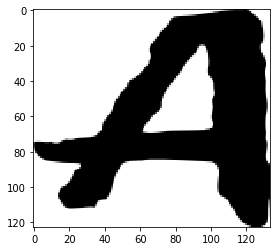

In [33]:
cropped_image, cropped_image_size = tight_crop_image(sample_arr, verbose=True)
plt.imshow(cropped_image, cmap='gray')
plt.show()

성공했다! 

## Padding

In [39]:
cropped_image.shape

(123, 134)

In [40]:
def add_padding(img, image_size=256, verbose=False, pad_value=1):
    height, width = img.shape
    if verbose:
        print('original cropped image size:', img.shape)
    
    # Adding padding of x axis - left, right
    pad_x_width = (image_size - width) // 2
    pad_x = np.full((height, pad_x_width), pad_value, dtype=np.float32)
    img = np.concatenate((pad_x, img), axis=1)
    img = np.concatenate((img, pad_x), axis=1)
    
    width = img.shape[1]

    # Adding padding of y axis - top, bottom
    pad_y_height = (image_size - height) // 2
    pad_y = np.full((pad_y_height, width), pad_value, dtype=np.float32)
    img = np.concatenate((pad_y, img), axis=0)
    img = np.concatenate((img, pad_y), axis=0)
    
    # Match to original image size
    width = img.shape[1]
    if img.shape[0] % 2:
        pad = np.full((1, width), pad_value, dtype=np.float32)
        img = np.concatenate((pad, img), axis=0)
    height = img.shape[0]
    if img.shape[1] % 2:
        pad = np.full((height, 1), pad_value, dtype=np.float32)
        img = np.concatenate((pad, img), axis=1)

    if verbose:
        print('final image size:', img.shape)
    
    return img

In [41]:
centered_image = add_padding(cropped_image, verbose=True)

original cropped image size: (123, 134)
final image size: (256, 256)


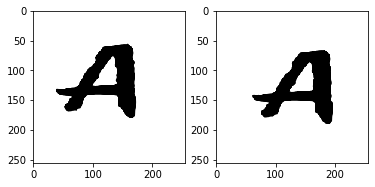

In [44]:
plt.subplot(121)
plt.imshow(sample_arr, cmap='gray')
plt.subplot(122)
plt.imshow(centered_image, cmap='gray')
plt.show()

Centering까지 완료! <br/>
전체 과정을 FontDataset 클래스에 추가하자.